## **Градиентный бустинг и итоговый анализ**

В этой части проекта применяется алгоритм XGBoost (Extreme Gradient Boosting) — одно из самых эффективных ансамблевых методов для задач классификации на табличных данных.
Используя предварительно подготовленный датасет кредитного риска, необходимо:
обучить базовую модель XGBoost:

*   обучить базовую модель XGBoost;
*   выполнить автоматический подбор гиперпараметров (RandomizedSearchCV);
*   сравнить качество базовой и оптимизированной моделей;
*   оценить модель по ключевым метрикам;
*   построить ROC-кривую и confusion matrix;

Этот этап демонстрирует, как градиентный бустинг улучшает качество прогнозирования кредитного риска и какие признаки оказывают наибольшее влияние на вероятность дефолта.

In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

from xgboost import XGBClassifier
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt

### Загрузка данных и train/test


In [12]:
df = pd.read_csv("credit_risk_preprocessed.csv")

y = df["loan_status"]
X = df.drop(columns=["loan_status"])

print("Форма датасета:", df.shape)
print("Целевая переменная (распределение классов):\n", y.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

Форма датасета: (32581, 23)
Целевая переменная (распределение классов):
 loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64


### Xgboost

In [23]:
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_base.fit(X_train, y_train)

proba_base = xgb_base.predict_proba(X_test)[:, 1]
pred_base = (proba_base >= 0.5).astype(int)

acc_base = accuracy_score(y_test, pred_base)
auc_base = roc_auc_score(y_test, proba_base)

print(f"Accuracy: {acc_base:.4f}")
print(f"ROC-AUC : {auc_base:.4f}")
print("\nClassification report (base):\n", classification_report(y_test, pred_base))
print("Confusion matrix (base):\n", confusion_matrix(y_test, pred_base))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:50:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9323
ROC-AUC : 0.9449

Classification report (base):
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.96      0.72      0.82      1422

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.89      6517
weighted avg       0.93      0.93      0.93      6517

Confusion matrix (base):
 [[5054   41]
 [ 400 1022]]


### RandomizedSearchCV: поиск гиперпараметров

In [22]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

param_dist = {
    "n_estimators": randint(200, 600),
    "max_depth": randint(3, 8),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0, 5),
    "reg_alpha": uniform(0, 5),
    "reg_lambda": uniform(0, 5)
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучший ROC-AUC (CV):", random_search.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:49:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Лучшие параметры: {'colsample_bytree': np.float64(0.6777095814048169), 'gamma': np.float64(0.3547045849996383), 'learning_rate': np.float64(0.08935676544277768), 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 342, 'reg_alpha': np.float64(1.87791476319972), 'reg_lambda': np.float64(0.469909699204345), 'subsample': np.float64(0.8313120563984696)}
Лучший ROC-AUC (CV): 0.943386801531415


RandomizedSearchCV перебрал 40 случайных комбинаций гиперпараметров XGBoost
в пространстве n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
min_child_weight, gamma, reg_alpha, reg_lambda с 3-fold cross-validation.

Лучшая конфигурация показала ROC-AUC на кросс-валидации = 0.9434,
что выше/сопоставимо с базовой моделью без подбора параметров.

По сути, RandomizedSearchCV автоматически нашёл баланс между глубиной деревьев,
числом деревьев, скоростью обучения и регуляризацией, который даёт наилучшее
обобщающее качество (по ROC-AUC) на обучающей выборке.

### Модель с лучшими гиперпараметрами

In [21]:
best_xgb = random_search.best_estimator_

proba_best = best_xgb.predict_proba(X_test)[:, 1]
pred_best = (proba_best >= 0.5).astype(int)

acc_best = accuracy_score(y_test, pred_best)
auc_best = roc_auc_score(y_test, proba_best)

print(f"Accuracy: {acc_best:.4f}")
print(f"ROC-AUC : {auc_best:.4f}")
print("\nClassification report (best):\n", classification_report(y_test, pred_best))
print("Confusion matrix (best):\n", confusion_matrix(y_test, pred_best))

Accuracy: 0.9345
ROC-AUC : 0.9502

Classification report (best):
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.96      0.73      0.83      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.86      0.89      6517
weighted avg       0.94      0.93      0.93      6517

Confusion matrix (best):
 [[5054   41]
 [ 386 1036]]


### Сводная таблица качества: базовая vs настроенная модель

In [20]:
metrics_df = pd.DataFrame({
    "model": ["XGB_base", "XGB_tuned"],
    "accuracy": [acc_base, acc_best],
    "roc_auc": [auc_base, auc_best]
})

print(metrics_df)

       model  accuracy   roc_auc
0   XGB_base  0.932331  0.944861
1  XGB_tuned  0.934479  0.950153


На тестовой выборке качество модели улучшилось:

- Accuracy: с 0.9323 до 0.9345
- ROC-AUC : с 0.9449 до 0.9502

Рост ROC-AUC означает, что настроенная модель лучше разделяет дефолтные
и недефолтные кредиты по шкале вероятностей. Улучшение Accuracy показывает,
что при стандартном пороге 0.5 увеличилась доля правильно классифицированных заявок.

Таким образом, подбор гиперпараметров дал более устойчивую и точную скоринговую модель.

###ROC-кривые: базовая vs настроенная модель

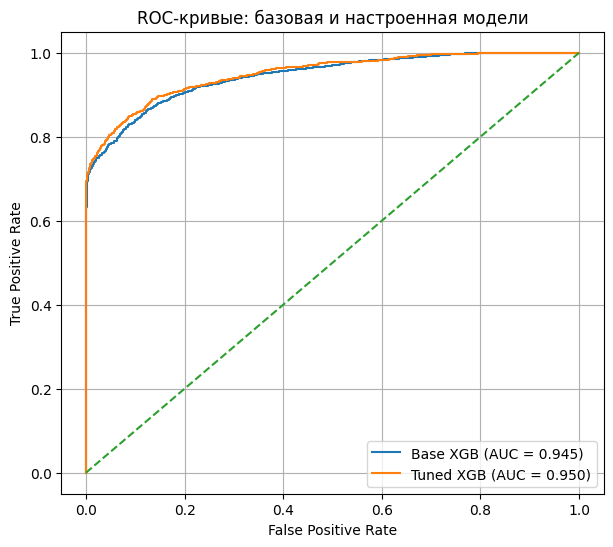

In [17]:
fpr_base, tpr_base, _ = roc_curve(y_test, proba_base)
fpr_best, tpr_best, _ = roc_curve(y_test, proba_best)

plt.figure(figsize=(7, 6))
plt.plot(fpr_base, tpr_base, label=f"Base XGB (AUC = {auc_base:.3f})")
plt.plot(fpr_best, tpr_best, label=f"Tuned XGB (AUC = {auc_best:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые: базовая и настроенная модели")
plt.legend()
plt.grid(True)
plt.show()

Интерпретация ROC-графика:
- Ось X — доля ложных срабатываний (False Positive Rate),
- Ось Y — доля правильно найденных дефолтов (True Positive Rate).
Кривая настроенной модели лежит выше базовой, что говорит о лучшем разделении
классов на всех возможных порогах. Чем больше AUC, тем лучше модель ранжирует
клиентов по риску дефолта.

### Confusion Matrix для лучшей модели

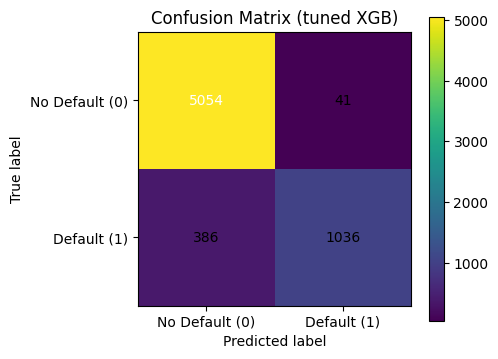

In [18]:
cm_best = confusion_matrix(y_test, pred_best)

plt.figure(figsize=(5, 4))
plt.imshow(cm_best, interpolation="nearest")
plt.title("Confusion Matrix (tuned XGB)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Default (0)", "Default (1)"])
plt.yticks(tick_marks, ["No Default (0)", "Default (1)"])
plt.xlabel("Predicted label")
plt.ylabel("True label")

thresh = cm_best.max() / 2.
for i in range(cm_best.shape[0]):
    for j in range(cm_best.shape[1]):
        plt.text(j, i, format(cm_best[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm_best[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


- [0,0] — True Negative: корректно одобренные надёжные клиенты.
- [0,1] — False Positive: ошибочно отклонённые хорошие клиенты.
- [1,0] — False Negative: пропущенные дефолты (самый дорогой тип ошибки для банка).
- [1,1] — True Positive: правильно отклонённые рискованные заявки.

Баланс между False Positive и False Negative можно дополнительно настраивать
через изменение порога вероятности.

### Feature Importance

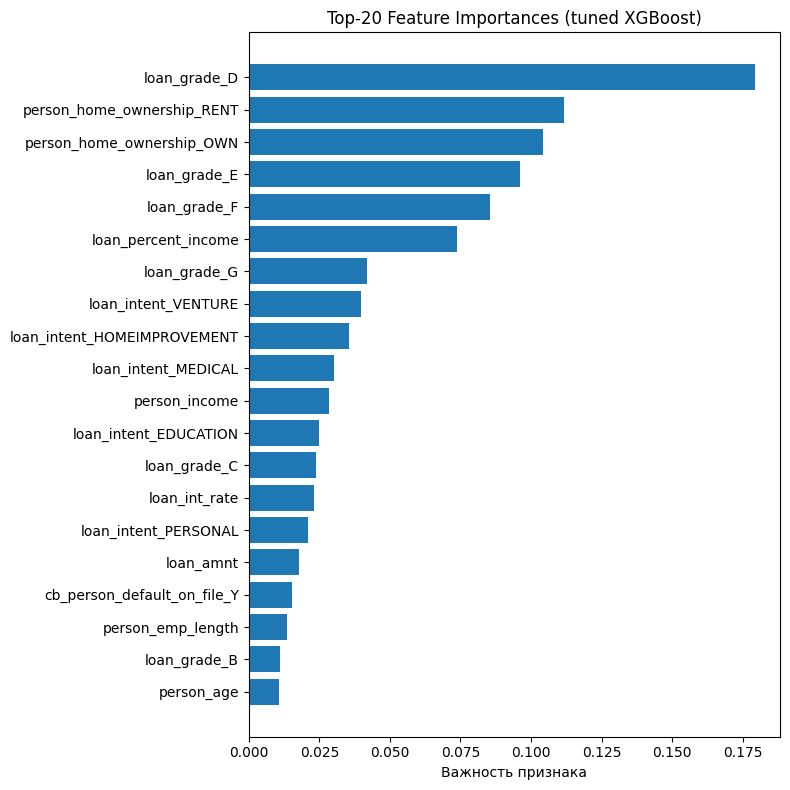

In [19]:
importances = best_xgb.feature_importances_
feat_names = X.columns

idx_sorted = np.argsort(importances)[::-1]
top_n = 20

plt.figure(figsize=(8, 8))
plt.barh(range(top_n), importances[idx_sorted][:top_n])
plt.yticks(range(top_n), feat_names[idx_sorted][:top_n])
plt.gca().invert_yaxis()
plt.title("Top-20 Feature Importances (tuned XGBoost)")
plt.xlabel("Важность признака")
plt.tight_layout()
plt.show()

Столбцы показывают вклад признаков в решение модели.
Верхние признаки (loan_percent_income, loan_int_rate, home_ownership, loan_grade и т.п.)
наиболее сильно влияют на прогноз дефолта. Это позволяет объяснить бизнесу,
какие факторы риск-модели считаются ключевыми.


XGBoost (Extreme Gradient Boosting) — ансамбль из множества решающих деревьев,
обучаемых по принципу градиентного бустинга. Для кредитного скоринга он подходит
особенно хорошо, потому что:

1) Отлично работает с табличными данными:
   - числовые признаки (доход, возраст, сумма кредита, процентная ставка);
   - бинарные/one-hot признаки (loan_intent, loan_grade, home_ownership).
   XGBoost улавливает нелинейные связи и взаимодействия между ними.

2) Устойчив к мультиколлинеарности и разным масштабам признаков.
   Нет необходимости в жёстком нормировании, как у линейных моделей.

3) Есть регуляризация (gamma, reg_alpha, reg_lambda),
   которая предотвращает переобучение и делает модель более стабильной
   на новых данных (новые клиенты, другие периоды времени).

4) Высокое качество ранжирования по вероятности дефолта:
   Метрика ROC-AUC показывает, насколько хорошо модель отделяет дефолтных
   клиентов от надёжных. В нашем случае настроенный XGBoost даёт высокий AUC,
   что важно для построения скоринговых порогов и стратегий cut-off.


In [25]:
import joblib

joblib.dump(best_xgb, "credit_risk_rf_model.pkl")
print("Model saved!")


Model saved!
